## Imports and Setup

### **If this is the first time setting up the notebook - make sure to set Runtime type to GPU !**

In [0]:
# This should be on the top of every Colab Notebook
# Enables normal file read/write functions in Python

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'fastai-v3/'

# After running this cell, click on the link and enter the code provided

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# Importing standard libraries
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import io
import dateutil
import cv2
sns.set_style('whitegrid')
%matplotlib inline


### ** Importing fastai.collab here so I can edit the source code **

In [0]:
"Module support for Collaborative Filtering"
from fastai.tabular import *
from fastai import tabular

__all__ = [*tabular.__all__, 'EmbeddingDotBias', 'EmbeddingNN', 'collab_learner', 'CollabDataBunch', 'CollabLine',
           'CollabList', 'CollabLearner']

class CollabProcessor(TabularProcessor):
    "Subclass `TabularProcessor for `process_one`."
    
    def process_one(self, item):
        res = super().process_one(item)
        return CollabLine(res.cats,res.conts,res.classes,res.names)

class CollabLine(TabularLine):
    "Base item for collaborative filtering, subclasses `TabularLine`."
    def __init__(self, cats, conts, classes, names):
        super().__init__(cats, conts, classes, names)
        self.data = [self.data[0][0],self.data[0][1]]

class CollabList(TabularList):
    "Base `ItemList` for collaborative filtering, subclasses `TabularList`."
    _item_cls,_label_cls,_processor = CollabLine,FloatList,CollabProcessor

    def reconstruct(self, t:Tensor): return CollabLine(tensor(t), tensor([]), self.classes, self.col_names)

class EmbeddingNN(TabularModel):
    "Subclass `TabularModel` to create a NN suitable for collaborative filtering."
    def __init__(self, emb_szs:ListSizes, **kwargs):
        super().__init__(emb_szs=emb_szs, n_cont=0, out_sz=1, **kwargs)

    def forward(self, users:LongTensor, items:LongTensor) -> Tensor:
        return super().forward(torch.stack([users,items], dim=1), None)

class EmbeddingDotBias(nn.Module):
    "Base dot model for collaborative filtering."
    def __init__(self, n_factors:int, n_users:int, n_items:int, y_range:Tuple[float,float]=None):
        super().__init__()
        self.y_range = y_range
        (self.u_weight, self.i_weight, self.u_bias, self.i_bias) = [embedding(*o) for o in [
            (n_users, n_factors), (n_items, n_factors), (n_users,1), (n_items,1)
        ]]

    def forward(self, users:LongTensor, items:LongTensor) -> Tensor:
        dot = self.u_weight(users)* self.i_weight(items)
        res = dot.sum(1) + self.u_bias(users).squeeze() + self.i_bias(items).squeeze()
        if self.y_range is None: return res
        
        # ZARIF - should the result be passed through Sigmoid function??
        return torch.sigmoid(res) * (self.y_range[1]-self.y_range[0]) + self.y_range[0]

class CollabDataBunch(DataBunch):
    "Base `DataBunch` for collaborative filtering."

    @classmethod
    def from_df(cls, ratings:DataFrame, pct_val:float=0.2, user_name:Optional[str]=None, item_name:Optional[str]=None,
                rating_name:Optional[str]=None, test:DataFrame=None, seed=None, **kwargs):
        "Create a `DataBunch` suitable for collaborative filtering from `ratings`."
        user_name   = ifnone(user_name,  ratings.columns[0])
        item_name   = ifnone(item_name,  ratings.columns[1])
        rating_name = ifnone(rating_name,ratings.columns[2])
        cat_names = [user_name,item_name]
        
        # The lines below is the data. DATA = src.databunch() - Zarif
        src = (CollabList.from_df(ratings, cat_names=cat_names, procs=Categorify)
               .random_split_by_pct(valid_pct=pct_val, seed=seed).label_from_df(cols=rating_name))
        
        CustomItemList = (CollabList.from_df(ratings, cat_names=cat_names, procs=Categorify))
                          
        CustomItemLists = (CollabList.from_df(ratings, cat_names=cat_names, procs=Categorify)
               .random_split_by_pct(valid_pct=pct_val, seed=seed))
        
        #print(CustomItemList.get(2))
        #print(CustomItemLists)

        
        if test is not None: src.add_test(CollabList.from_df(test, cat_names=cat_names))
        return src.databunch(**kwargs)

class CollabLearner(Learner):
    "`Learner` suitable for collaborative filtering."
    def get_idx(self, arr:Collection, is_item:bool=True):
        "Fetch item or user (based on `is_item`) for all in `arr`. (Set model to `cpu` and no grad.)"
        m = self.model.eval().cpu()
        requires_grad(m,False)
        u_class,i_class = self.data.classes.values()
        classes = i_class if is_item else u_class
        c2i = {v:k for k,v in enumerate(classes)}
        return tensor([c2i[o] for o in arr])

    def bias(self, arr:Collection, is_item:bool=True):
        "Bias for item or user (based on `is_item`) for all in `arr`. (Set model to `cpu` and no grad.)"
        idx = self.get_idx(arr, is_item)
        m = self.model
        layer = m.i_bias if is_item else m.u_bias
        return layer(idx).squeeze()

    def weight(self, arr:Collection, is_item:bool=True):
        "Bias for item or user (based on `is_item`) for all in `arr`. (Set model to `cpu` and no grad.)"
        idx = self.get_idx(arr, is_item)
        m = self.model
        layer = m.i_weight if is_item else m.u_weight
        return layer(idx)

def collab_learner(data, n_factors:int=None, use_nn:bool=False, metrics=None,
                   emb_szs:Dict[str,int]=None, wd:float=0.01, **kwargs)->Learner:
    "Create a Learner for collaborative filtering on `data`."
    emb_szs = data.get_emb_szs(ifnone(emb_szs, {}))
    u,m = data.classes.values()
    if use_nn: 
      model = EmbeddingNN(emb_szs=emb_szs, **kwargs)
      print('Embedding NN')
    else:      
      model = EmbeddingDotBias(n_factors, len(u), len(m), **kwargs)
      print('Embedding Dot Bias')
    return CollabLearner(data, model, metrics=metrics, wd=wd)



In [0]:
# Importing fastAI libraries
#from fastai.collab import *
from fastai.tabular import *
# Fixing Attribute error
get_ipython().config.get('IPKernelApp', {})['parent_appname'] = ""
CUDA_LAUNCH_BLOCKING=1

### Only run this section when you need to import files



In [0]:
# from google.colab import files
# uploaded = files.upload()
# for fn in uploaded.keys():
#   print('User uploaded file "{name}" with length {length} bytes'.format(
#       name=fn, length=len(uploaded[fn])))

## Uploading Aggregated Data

Aggregated Data is the name for the data where the amounts for every Journal ID and every GL Account are summed up into one value. Before aggregating, the structure of the data had multiple dollar amounts for every Journal_ID and GL Account. This is equivalent to one user having multiple ratings for the same movie, which doesn't make sense. Hence the data was aggregated using the following method:

df_grouped = df1.groupby(['Journal_ID','GL_Account'])['Amount'].sum().reset_index()

In [0]:
# LOADING AGGREGATED DATA FROM GOOGLE DRIVE
df_grouped = pd.read_csv('/content/gdrive/My Drive/fastai-v3/real_aggregated_data.csv')
df_grouped = df_grouped.drop(['Unnamed: 0'], axis=1)
df_grouped.head(12)

,Journal_ID,GL_Account,Amount
0,1,1265,-71069.44
1,1,3320,71069.44
2,10,1265,-24604.95
3,10,3320,24604.95
4,100,1265,-50774.00
5,100,3320,50774.00
6,1000,1265,244000.00
7,1000,1281,-244000.00
8,10000,1310,2762.76
9,10000,3620,-251.16


In [0]:
# Grouping up the data as above definitely seems the way to go. It also reduced our data size to half.
# changing the Journal_ID type to string so that the groupby function below works correctly

df_grouped['Journal_ID'] = df_grouped.Journal_ID.astype(str)
df_grouped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 190838 entries, 0 to 190837
Data columns (total 3 columns):
Journal_ID    190838 non-null object
GL_Account    190838 non-null int64
Amount        190838 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 4.4+ MB


##  Scaling the Data


-  To reduce our training error down from the millions, we have to scale the data down to a reasonable range

- We have to create a scaling vector that transforms all the amounts between -1 and 1 by dividing by the biggest number in that particular transaction ID. We should store the unique scaling factor for every transaction ID in a **scaling dictionary**.
- The scaling dictionary is necessary for converting the scaled amounts back to their real amounts in dollars.

- Find the maximum Amount in every transaction ID and divide by that amount

In [0]:
scaling_vector = df_grouped.groupby(['Journal_ID'], as_index=False)['Amount'].max()
scaling_vector.head()

,Journal_ID,Amount
0,1,71069.44
1,10,24604.95
2,100,50774.00
3,1000,244000.00
4,10000,2762.76


In [0]:
# Creating the scaling dictionary, this is useful for converting back the scaled amounts into their real amounts
scaling_dict  = dict(zip(scaling_vector.Journal_ID, scaling_vector.Amount))

# To find the scaling factor for Transaction_ID = 1 :
scaling_dict['1']

71069.44

In [0]:
# Using the 'apply' function to scale the Amounts to between -1 and 1
def scale(key, amount):
  scale_factor = scaling_dict[str(key)]
  if scale_factor ==0: scale_factor = 1
    
  return (amount/scale_factor)
  #return scale_factor

df_grouped['Scaled_Amount'] = df_grouped.apply(lambda row: scale(row['Journal_ID'], row['Amount']), axis=1)

# Cleaning up data after scaling
df_scaled = df_grouped.drop(['Amount'], axis=1)
df_scaled.columns = ['Journal_ID','GL_Account','Amount']

**As you can see below - all the amounts have been converted to between -1 and 1 !**

In [0]:
df_scaled.tail()
df_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 190838 entries, 0 to 190837
Data columns (total 3 columns):
Journal_ID    190838 non-null object
GL_Account    190838 non-null int64
Amount        190838 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 4.4+ MB


# Fitting data into Collab Model

## Attempt 3 - After scaling the data

In [0]:
scaled_data = CollabDataBunch.from_df(df_scaled, seed=42, user_name = 'Journal_ID', pct_val=0.1, item_name='GL_Account')

#?? CollabDataBunch
#?? collab_learner

#scaled_data.show_batch()
#scaled_data.from_df()

In [0]:
# Now we can input a y_range because our Amounts are scaled
y_range = [-1.05,1.05]
learn = collab_learner(scaled_data, n_factors=50, y_range=y_range, wd=1e-1)

Embedding Dot Bias


## Learning rate finder
### Even though 1e-6 seems like the best option, 5e-3 works the best

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


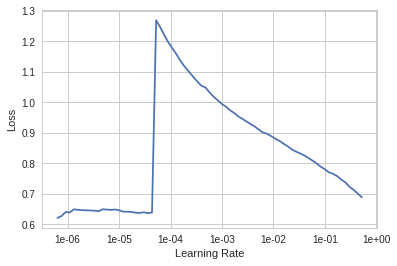

In [0]:
learn.lr_find()
learn.recorder.plot(skip_end=15)

In [0]:
learn.fit_one_cycle(4, 1e-3)

epoch,train_loss,valid_loss
1,0.310592,0.302407
2,0.088691,0.106607
3,0.049848,0.081379
4,0.033003,0.077453


In [0]:
# Make sure to save the models within your mounted gdrive, otherwise they will be lost when you restart Colab
learn.save(base_dir + 'scaled_weights2')

# Getting Predictions

In [0]:
#learn.load(base_dir + 'scaled_weights1');
learn.load(base_dir + 'scaled_weights2');

df_scaled.tail()

,Journal_ID,GL_Account,Amount
190833,9998,3620,-0.090918
190834,9998,6210,-0.909082
190835,9999,1310,1.000000
190836,9999,3620,-0.090909
190837,9999,6210,-0.909091


In [0]:
#?? learn.predict()
# the first one is the prediction of the Amount
# the second item is the label
# the third one is the probability that it's in that category

# testing out the predict function
#prediction, label, perc = learn.predict(df_scaled.iloc[190736,[0,1]])
#float(prediction.data)
#float(learn.predict(df_scaled.iloc[190736,[0,1]])[0].data)

### Custom predictor function

In [0]:

"""
Author: Zarif
custom_predictor() is a way to check the real accuracy of our model
returns the predicted amount and the actual amount in that transaction.
There is an existing error with the % error calculation, this was fixed in the 
further functions
"""

def custom_predictor1(learn_model, index, df):
  
  learn.load(learn_model)
  
  # Getting scaled values
  actual_scaled = df.iloc[index, 2]
  pred_scaled = float(learn.predict(df.iloc[index,[0,1]])[0].data)
  
  # Getting the Journal_ID for our specific index
  journal_id = df.iloc[index,0]
  
  # returns a float which is the scaling factor used for that ID
  scaling_factor = scaling_dict[journal_id]
  
  # Getting raw values from the original journal
  actual_raw = actual_scaled*scaling_factor
  pred_raw = float(pred_scaled)*scaling_factor
  
  
  sys.stdout.flush()
  
  print('Scaled Values')
  print("Actual Amount:    {0:.9f}".format(actual_scaled))
  print('Predicted Amount: {0:.9f}'.format(pred_scaled))
  
  print("\n\nRaw Values\nActual Amount:    ${0:.2f}".format(actual_raw))
  print("Predicted Amount: ${0:.2f}".format(pred_raw))
  
  error = (actual_raw - pred_raw)/actual_raw*100 
  
  print("Percentage error: {0:.2f}%".format(error))

In [1]:
# ERROR: for some reason pred_scaled value is being overwritten
# update: the function works
learn_model = base_dir + 'scaled_weights2'
line_index = 373

custom_predictor1(learn_model, line_index, df_scaled)

NameError: ignored

In [0]:
df_scaled.iloc[371,0]

In [0]:
df_scaled[df_scaled.Journal_ID == '3456']

## Error calculation

In [0]:
"""
Author : Zarif
returns the absolute percentage error of prediction value compared to real value
Basically a simpler version of the custom_predictor fn that has only 1 outptut
this function needs to be made for efficient
"""
def error_calculator(index, df):
  #learn.load(learn_model)
  
  # Getting scaled values
  actual_scaled = df.iloc[index, 2]
  pred_scaled = float(learn.predict(df.iloc[index,[0,1]])[0].data)
  #pred_scaled = 2
  
  # Getting the Journal_ID for our specific index
  journal_id = df.iloc[index,0]
  
  # returns a float which is the scaling factor used for that ID
  scaling_factor = scaling_dict[journal_id]
  
  # Getting raw values from the original journal
  actual_raw = actual_scaled*scaling_factor
  pred_raw = float(pred_scaled)*scaling_factor
  
  # Calculating error using a special method
  # the if condition accounts for the fact that both actual and pred values are 
  # 0 so error should be 0 instead of 'nan'
  error = 0 if (actual_raw == pred_raw == 0) else (actual_raw - pred_raw)/((abs(pred_raw)+abs(actual_raw))/2) 
  
  return error

In [0]:
# error_array = df_scaled.apply(lambda row: error_calculator(learn_model, row, df_scaled), axis=1)

error_calculator(359, df_scaled)

In [0]:
df_scaled.tail(5)

In [0]:
# Takes a long time to run
# ran at 11:37 and ended around 12:20 - so around 40 mins

error_array = []

for i in range(0,190838):
  error_array.append(error_calculator(i, df_scaled))

In [0]:
# Turning our error_array into a dataset
# Checking the tail end of the dataset to make sure the correct number of rows are present

error_dataset1 = pd.DataFrame({'Errors':error_array[:]})
error_dataset1.tail()

In [0]:
error_dataset1.info()

In [0]:
# Error log:
# Error_dataset1 and 2 had the previous method of calculating errors which gave us inf values when dividing by $0
# Error_dataset3 is calculated using the new method but still has some missing values. The issue was found to be: 0/0 = nan
# Error_dataset4 is calculated after turning nan values into 0

error_dataset1.to_csv(path_or_buf = base_dir + 'error_dataset5.csv')
error_dataset1.hist(bins=100)

NameError: ignored

In [0]:
# This is the screenshot of the first error histogram
img = cv2.imread("error_hist_1.PNG")
img_cvt=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_cvt)
plt.show()

In [0]:
# This is the screenshot of the second error histogram - much better performance
img = cv2.imread("error_hist_2.PNG")
img_cvt=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_cvt)
plt.show()

## Error distribution and Accuracy

In [0]:
def error_distribution(df):
  
  total_length = len(df.index)
  one_perc = five_perc = ten_perc = fifteen_perc = twenty_perc = thirty_perc \
    = fourty_perc = fifty_perc = over_fifty = 0
  
  for index, row in df.iterrows():
    value = abs(row['Errors'])
    
    if value <= 0.01:
      one_perc += 1
      five_perc += 1
      ten_perc += 1
      fifteen_perc += 1
      twenty_perc += 1
      thirty_perc += 1
      fourty_perc += 1
      fifty_perc += 1
    elif value <= 0.05:
      five_perc += 1
      ten_perc += 1
      fifteen_perc += 1
      twenty_perc += 1
      thirty_perc += 1
      fourty_perc += 1
      fifty_perc += 1      
    elif value <= 0.1:
      ten_perc += 1
      fifteen_perc += 1
      twenty_perc += 1
      thirty_perc += 1
      fourty_perc += 1
      fifty_perc += 1
    elif value <= 0.15:
      fifteen_perc += 1
      twenty_perc += 1
      thirty_perc += 1
      fourty_perc += 1
      fifty_perc += 1
    elif value <= 0.2:
      twenty_perc += 1
      thirty_perc += 1
      fourty_perc += 1
      fifty_perc += 1
    elif value <= 0.3:
      thirty_perc += 1
      fourty_perc += 1
      fifty_perc += 1
    elif value <= 0.4:
      fourty_perc += 1
      fifty_perc += 1
    elif value <= 0.5:
      fifty_perc += 1
    else:
      over_fifty += 1
      
  print("Sub   1%: {0:.2f}%".format(one_perc/total_length*100))
  print("Sub   5%: {0:.2f}%".format(five_perc/total_length*100))
  print("Sub  10%: {0:.2f}%".format(ten_perc/total_length*100))
  print("Sub  15%: {0:.2f}%".format(fifteen_perc/total_length*100))
  print("Sub  20%: {0:.2f}%".format(twenty_perc/total_length*100))
  print("Sub  30%: {0:.2f}%".format(thirty_perc/total_length*100))
  print("Sub  40%: {0:.2f}%".format(fourty_perc/total_length*100))
  print("Sub  50%: {0:.2f}%".format(fifty_perc/total_length*100))
  print("Over 50%: {0:.2f}%".format(over_fifty/total_length*100))

In [0]:
error_distribution(error_dataset1)

In [0]:
learn.show_results()

# Getting embedding matrix for Journal IDs

Once we are satisfied with the accuracy of our model, the final step is to extract the embedding vectors for each Journal ID. The embedding vector for every ID is the end goal of this notebook, as this is the vector that represents the transactions for that Journal ID in a vector space.

In [0]:
# User_weights = Journal_ID weights 

embedding = learn.model.u_weight
embedding


In [0]:
# a batch of 2 samples of 4 indices each
#input = torch.LongTensor([[1,2,4,5],[4,3,2,9]]
length_of_embedding = 64382

embedding_list = list(range(0, 64382))
input = torch.cuda.LongTensor(embedding_list)

tensor_array = embedding(input)
#width_of_embedding = len(tensor_array.cpu().detach().numpy()[0])
tensor_array.cpu().detach().numpy()

# Trying to extract Validation dataset

We need to do this so that we can run our error_calculator() only over the validation dataset and not the entire dataset as a whole. Basing our error distribution on the entire dataset will give us a misleading statistic as the model has been trained on 80-90% of that dataset in the first place.

Findings:
- 'Dumb' way of extracting the valid_ds has been found. Where you iterrate over all the rows of the LabelList item and get() each value and store it into array. Smart way has yet to be found.
- scaled_data.valid_ds.get().data[] returns a tensor object which seems to be index of the data point and not the actual data
- scaled_data.valid_ds.get(5).classes returns an OrderedDict item which contains an ordered array of every Journal_ID and every GL_Account.
- structure of the OrderedDict is strange and I couldn't index into it to get a particular data point out. Should be able to do with more time.

In [0]:
type(scaled_data.valid_ds)

fastai.data_block.LabelList

In [0]:
scaled_data.valid_ds

LabelList
y: FloatList (19083 items)
[FloatItem -0.9090902, FloatItem -0.0909078, FloatItem -1.0, FloatItem -0.09091207, FloatItem 1.0]...
Path: .
x: CollabList (19083 items)
[CollabLine Journal_ID 49782; GL_Account 6210; , CollabLine Journal_ID 44937; GL_Account 3620; , CollabLine Journal_ID 62701; GL_Account 1310; , CollabLine Journal_ID 22196; GL_Account 3620; , CollabLine Journal_ID 25120; GL_Account 1310; ]...
Path: .

In [0]:
#scaled_data.valid_ds.get(1)
array = []

for row in range(0,len(scaled_data.valid_ds)):
  array.append(str(scaled_data.valid_ds.get(row)))
  
#valid_df = pd.DataFrame.from_records(array, columns = labels)
#type(array[0])
array

['Journal_ID 49782; GL_Account 6210; ',
 'Journal_ID 44937; GL_Account 3620; ',
 'Journal_ID 62701; GL_Account 1310; ',
 'Journal_ID 22196; GL_Account 3620; ',
 'Journal_ID 25120; GL_Account 1310; ',
 'Journal_ID 25138; GL_Account 1310; ',
 'Journal_ID 15497; GL_Account 3620; ',
 'Journal_ID #na#; GL_Account 1310; ',
 'Journal_ID 9628; GL_Account 1310; ',
 'Journal_ID 51751; GL_Account 6260; ',
 'Journal_ID 18416; GL_Account 3620; ',
 'Journal_ID 58395; GL_Account 1281; ',
 'Journal_ID 53324; GL_Account 3320; ',
 'Journal_ID #na#; GL_Account 1310; ',
 'Journal_ID 1061; GL_Account 3485; ',
 'Journal_ID 38678; GL_Account 3620; ',
 'Journal_ID 36103; GL_Account 1310; ',
 'Journal_ID 61700; GL_Account 1281; ',
 'Journal_ID 4557; GL_Account 6210; ',
 'Journal_ID 48114; GL_Account 6510; ',
 'Journal_ID 64204; GL_Account 1281; ',
 'Journal_ID 829; GL_Account 3430; ',
 'Journal_ID 25968; GL_Account 6210; ',
 'Journal_ID 44112; GL_Account 6210; ',
 'Journal_ID 33824; GL_Account 3620; ',
 'Journ

In [0]:
array = []

array.append(scaled_data.valid_ds.get(2))
type(array[0])

__main__.CollabLine

In [0]:
scaled_data.valid_ds.get(0).data[1]

tensor(62)

In [0]:
scaled_data.valid_ds.get(0).data[1].numpy()

array(62)

In [0]:
type(scaled_data.valid_ds.get(1).data[1].numpy())

numpy.ndarray

In [0]:
# the output is just a number, which is probably an index
scaled_data.valid_ds.get(0).data[1].numpy().tolist()

62

In [0]:
scaled_data.valid_ds.get(5).classes

OrderedDict([('Journal_ID',
              array(['#na#', '1', '10', '100', ..., '9996', '9997', '9998', '9999'], dtype=object)),
             ('GL_Account',
              array(['#na#', '1210', '1220', '1260', ..., '9610', '9625', '9626', '9700'], dtype='<U21'))])

In [0]:
# This seems to just contain a dict of every single Journal_ID
#deadend

scaled_data.valid_ds.get(5).classes['Journal_ID']

array(['#na#', '1', '10', '100', ..., '9996', '9997', '9998', '9999'], dtype=object)

In [0]:
scaled_data.valid_ds.get(5).classes.items()

odict_items([('Journal_ID', array(['#na#', '1', '10', '100', ..., '9996', '9997', '9998', '9999'], dtype=object)), ('GL_Account', array(['#na#', '1210', '1220', '1260', ..., '9610', '9625', '9626', '9700'], dtype='<U21'))])